In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm

import nltk
nltk.download('punkt')

from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# ROOT PATHS (relative to notebooks folder)
IMAGES_DIR = "../dataset/Images"
CAPTIONS_FILE = "../dataset/captions.txt"

# MODELS
MODEL_PATH = "../outputs/models/model.keras"
FEATURE_EXTRACTOR_PATH = "../outputs/models/feature_extractor.keras"
TOKENIZER_PATH = "../outputs/models/tokenizer.pkl"

image_size = 224
max_length = 34



In [3]:
print("Loading models...")

caption_model = load_model(MODEL_PATH)
feature_extractor = load_model(FEATURE_EXTRACTOR_PATH)

with open(TOKENIZER_PATH, "rb") as f:
    tokenizer = pickle.load(f)

print("Models loaded ✅")


Loading models...
Models loaded ✅


In [4]:
import csv

def load_references(caption_file):
    references = {}

    with open(caption_file, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)

        for row in reader:
            image_name = row["image"]
            caption = row["caption"].lower()

            if image_name not in references:
                references[image_name] = []

            references[image_name].append(caption)

    return references

references_dict = load_references(CAPTIONS_FILE)

print("Total Images:", len(references_dict))


Total Images: 8091


In [5]:
import os

print(os.path.exists("../dataset/captions.txt"))
print(os.path.exists("../dataset/Images"))


True
True


In [6]:
def generate_caption(image_path):
    img = load_img(image_path, target_size=(image_size, image_size))
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)

    feature = feature_extractor.predict(img, verbose=0)

    in_text = "startseq"

    for _ in range(max_length):
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq], maxlen=max_length)

        yhat = caption_model.predict([feature, seq], verbose=0)
        yhat_idx = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_idx)

        if word is None:
            break

        in_text += " " + word
        if word == "endseq":
            break

    caption = in_text.replace("startseq", "").replace("endseq", "").strip()
    return caption


In [7]:
references_dict = load_references(CAPTIONS_FILE)


print("Total images:", len(references_dict))
print("Sample:", list(references_dict.items())[:1])


Total images: 8091
Sample: [('1000268201_693b08cb0e.jpg', ['a child in a pink dress is climbing up a set of stairs in an entry way .', 'a girl going into a wooden building .', 'a little girl climbing into a wooden playhouse .', 'a little girl climbing the stairs to her playhouse .', 'a little girl in a pink dress going into a wooden cabin .'])]


In [8]:
import random

# Convert keys to a list
all_images = list(references_dict.keys())

# Randomly select 1000 images
TEST_SIZE = 1000
test_images = random.sample(all_images, TEST_SIZE)


In [9]:
y_true = []
y_pred = []

print("Generating captions for 1000 images...")

for image_name in tqdm(test_images):
    img_path = os.path.join(IMAGES_DIR, image_name)

    if not os.path.exists(img_path):
        continue

    try:
        pred_caption = generate_caption(img_path)
        refs = references_dict[image_name]

        y_true.append([r.split() for r in refs])
        y_pred.append(pred_caption.split())

    except Exception as e:
        print(f"Error on {image_name}:", e)


Generating captions for 1000 images...


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [12:20<00:00,  1.35it/s]


In [10]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
import numpy as np

# ----- BLEU -----
bleu1 = corpus_bleu(y_true, y_pred, weights=(1, 0, 0, 0))
bleu2 = corpus_bleu(y_true, y_pred, weights=(0.5, 0.5, 0, 0))
bleu3 = corpus_bleu(y_true, y_pred, weights=(1/3, 1/3, 1/3, 0))
bleu4 = corpus_bleu(y_true, y_pred, weights=(0.25, 0.25, 0.25, 0.25))


In [11]:
print("\nBLEU Scores:")
print(f"  BLEU-1:  {bleu1:.4f}")
print(f"  BLEU-2:  {bleu2:.4f}")
print(f"  BLEU-3:  {bleu3:.4f}")
print(f"  BLEU-4:  {bleu4:.4f}")



BLEU Scores:
  BLEU-1:  0.5049
  BLEU-2:  0.3174
  BLEU-3:  0.1912
  BLEU-4:  0.1135


In [12]:
meteor_scores = []
for refs, hyp in zip(y_true, y_pred):
    meteor_scores.append(meteor_score(refs, hyp))

meteor_avg = np.mean(meteor_scores)
print(f"\nMETEOR:   {meteor_avg:.4f}")



METEOR:   0.2773


In [13]:
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

precisions, recalls, f1s = [], [], []

for refs, hyp in zip(y_true, y_pred):
    hyp_text = " ".join(hyp)

    best_p, best_r, best_f = 0, 0, 0
    for ref in refs:
        ref_text = " ".join(ref)
        s = scorer.score(ref_text, hyp_text)['rougeL']

        best_p = max(best_p, s.precision)
        best_r = max(best_r, s.recall)
        best_f = max(best_f, s.fmeasure)

    precisions.append(best_p)
    recalls.append(best_r)
    f1s.append(best_f)

In [14]:
print("\nROUGE-L Scores:")
print(f"  Precision: {np.mean(precisions):.4f}")
print(f"  Recall:    {np.mean(recalls):.4f}")
print(f"  F1-Score:  {np.mean(f1s):.4f}")



ROUGE-L Scores:
  Precision: 0.4519
  Recall:    0.3534
  F1-Score:  0.3745


In [15]:
import pandas as pd

df = pd.DataFrame({
    "Metric": ["BLEU-1", "BLEU-2", "BLEU-3", "BLEU-4", "METEOR", "ROUGE-L (F1)"],
    "Score": [bleu1, bleu2, bleu3, bleu4, meteor_avg, np.mean(f1s)]
})

print("\n===== MODEL EVALUATION RESULTS =====\n")
display(df)



===== MODEL EVALUATION RESULTS =====



,Metric,Score
0,BLEU-1,0.504884
1,BLEU-2,0.317433
2,BLEU-3,0.191181
3,BLEU-4,0.113471
4,METEOR,0.277254
5,ROUGE-L (F1),0.374470


In [16]:
import os

image_paths = []

for fname in os.listdir(IMAGES_DIR):
    if fname.lower().endswith((".jpg", ".jpeg", ".png")):
        full_path = os.path.join(IMAGES_DIR, fname)
        if os.path.exists(full_path):
            image_paths.append(full_path)

print("Total images found:", len(image_paths))
print("First 5 images:", image_paths[:5])


Total images found: 8091
First 5 images: ['../dataset/Images\\1000268201_693b08cb0e.jpg', '../dataset/Images\\1001773457_577c3a7d70.jpg', '../dataset/Images\\1002674143_1b742ab4b8.jpg', '../dataset/Images\\1003163366_44323f5815.jpg', '../dataset/Images\\1007129816_e794419615.jpg']


In [17]:
import random

def show_samples(n=5):
    if not image_paths:
        print("❌ No images found")
        return

    sample_paths = random.sample(image_paths, n)

    for img_path in sample_paths:
        img_name = os.path.basename(img_path)

        pred = generate_caption(img_path)
        refs = references_dict.get(img_name, [])

        print("\nImage:", img_name)
        print("References:")
        for r in refs[:3]:
            print(" -", r)

        print("Prediction:")
        print(" >", pred)
        print("-" * 50)


In [18]:
show_samples(5)



Image: 418667611_b9995000f4.jpg
References:
 - a surfboard is shown gliding through the water with a person standing on it .
 - a surfer rides a green board over the waves .
 - a surfer rides the wave out .
Prediction:
 > man in wetsuit is surfing
--------------------------------------------------

Image: 3525417522_7beb617f8b.jpg
References:
 - a daschund leaps through short grass .
 - a small brown dog runs through the grass in front of another dog and their owners .
 - a small dog leaping , but not very high .
Prediction:
 > two dogs are running through the grass
--------------------------------------------------

Image: 1417637704_572b4d6557.jpg
References:
 - two children peek out .
 - two children with brown hair in a trunk of a car .
 - two small children pop their heads out of the trunk of a car in cold weather .
Prediction:
 > two children are sitting on the side of the street
--------------------------------------------------

Image: 3688839836_ba5e4c24fc.jpg
References:
 - 

In [19]:
print("Images loaded:", len(image_paths))
print("References loaded:", len(references_dict))


Images loaded: 8091
References loaded: 8091


In [20]:
import matplotlib.pyplot as plt
from PIL import Image
import random
import os

def show_samples(n=5):
    if not image_paths:
        print("❌ No images found")
        return

    sample_paths = random.sample(image_paths, n)

    for img_path in sample_paths:
        img_name = os.path.basename(img_path)

        # Generate caption
        pred = generate_caption(img_path)
        refs = references_dict.get(img_name, [])

        # --- Display image ---
        img = Image.open(img_path)

        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis("off")

        # --- Title (Prediction) ---
        plt.title(f"PREDICTED:\n{pred}", fontsize=12)

        plt.show()

        # --- Print reference captions ---
        print("Image filename:", img_name)
        print("Reference captions:")
        for r in refs[:3]:
            print(" -", r)

        print("\nPredicted caption:")
        print(" >", pred)
        print("=" * 60)


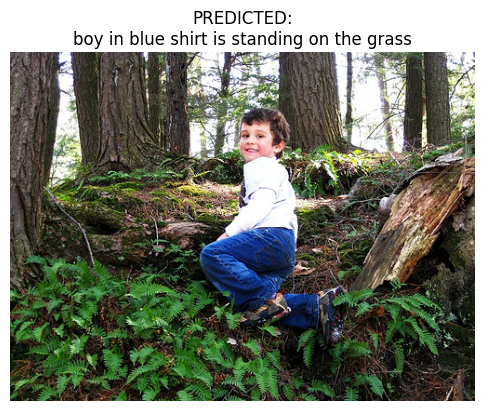

Image filename: 2424111022_4e332b8aee.jpg
Reference captions:
 - a boy in the woods .
 - a boy wearing a white shirt climbs on a forest hill .
 - a little boy in blue jeans climbs a small incline in the woods and turns around to smile .

Predicted caption:
 > boy in blue shirt is standing on the grass


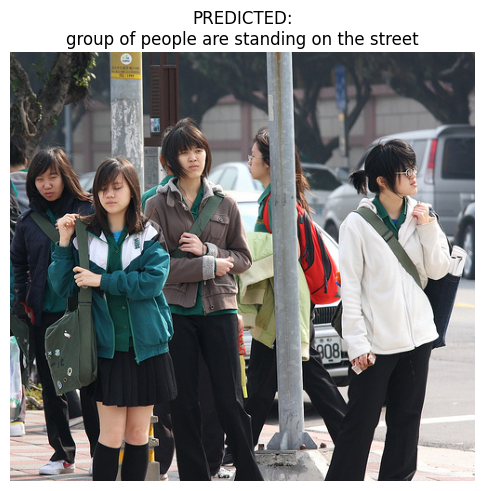

Image filename: 3276475986_66cd9cc7e4.jpg
Reference captions:
 - asian women standing near a pole .
 - several asian women are standing on the street .
 - the four asian girls are standing on a street corner , all with book bags on their shoulders .

Predicted caption:
 > group of people are standing on the street


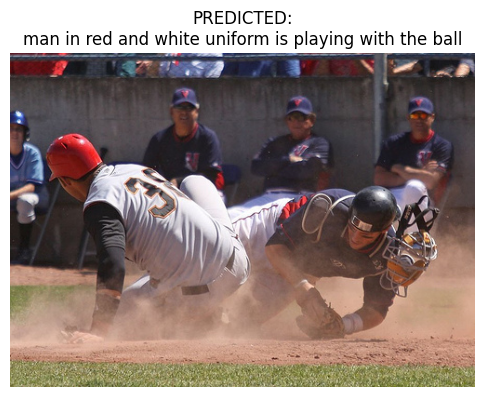

Image filename: 3681324243_b69fa90842.jpg
Reference captions:
 - a baseball player slides to the base .
 - a catcher tries to beat a runner to home plate .
 - a person playing baseball slides for home .

Predicted caption:
 > man in red and white uniform is playing with the ball


In [21]:
show_samples(3)
